In [ ]:
!echo $CONDA_PREFIX

In [ ]:
import numpy as np
from IPython.display import Audio
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t**2)
Audio(data,rate=framerate)

In [1]:
import torch
from DNN import *
from data_utils import *
from data_dist import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from train_round import *
import matplotlib.pyplot as plt
from d2denvironment import *
import statistics
dataset = 'mnist'
num_nodes = 4
train, test = dataset_select(dataset)

In [ ]:
traindist = data_iid(train, num_nodes)
base_model = Net(10, 1, dataset)
sgd_model = copy.deepcopy(base_model).cuda()
models = {node:copy.deepcopy(base_model).cuda() for node in range(num_nodes)}
optim_set = {node:torch.optim.SGD(model.parameters(), lr = 0.01) for node, model in models.items()}

trgloss_dict = {node:[] for node in range(num_nodes)}
for rnd in range(10):
    loss_dict, _ = local_update(3, models, 10, 1, train, traindist, 8)
    aggregated_model = server_aggregate(models, list(range(num_nodes)), 10, 1, dataset)
    for node, loss in loss_dict.items():
                    trgloss_dict[node] += loss
            
for node in range(num_nodes):
    plt.figure()
    plt.plot(trgloss_dict[node])
    
loss_dict = {node:[] for node in range(num_nodes)}
models2 = {node:copy.deepcopy(base_model).cuda() for node in range(num_nodes)}
optim_set = {node:torch.optim.SGD(model.parameters(), lr = 0.01) for node, model in models2.items()}
for rnd in range(10):
    for node, model in models2.items():
        for epoch in tqdm(range(3)):
            loss = client_update(model, optim_set[node], DataLoader(DataSubset(train, traindist, node), batch_size = 16)) 
            loss_dict[node].append(loss)
    base_model = Net(10, 1, dataset).cuda()
    for key in base_model.state_dict().keys():
        for node, model in models.items():
            base_model.state_dict()[key] += model.state_dict()[key]
        base_model.state_dict()[key] = torch.div(base_model.state_dict()[key], len(models))
        
import matplotlib.pyplot as plt
for node in range(num_nodes):
    plt.figure()
    plt.plot(loss_dict[node])

In [647]:
files = os.listdir('./Results/')
result_files = []
for file in files:
    if 'results' in file:
        result_files.append(file)
result_files.remove(result_files[0])

In [633]:
with open(os.path.join('./Results/',  'resultscifar_niid_n20_c3_e2_20210818-1420'), 'rb') as f:
        state_latest =  pickle.load(f)


In [648]:
result_files

['resultsmnist_niid1_n20_c3_e3_20210818-2144',
 'resultsmnist_iid_n20_c3_e3_20210818-2151',
 'resultscifar_niid1_n30_c5_e3_20210817-0043',
 'resultsmnist_niid2_n20_c3_e3_20210819-0207',
 'resultsmnist_niid2_n20_c3_e3_20210819-0856',
 'resultscifar_niid1_n20_c3_e3_20210819-0805',
 'resultscifar_iid_n20_c3_e2_20210818-1412',
 'resultscifar_iid_n20_c3_e3_20210818-1843',
 'resultscifar_iid_n30_c5_e2_20210816-1627',
 'resultscifar_niid_n20_c3_e2_20210818-1420',
 'resultsmnist_niid1_n20_c3_e3_20210819-0904',
 'resultsmnist_niid1_n20_c3_e3_20210819-0043',
 'resultsmnist_iid_n20_c3_e2_20210818-0849',
 'resultsmnist_niid1_n30_c5_e3_20210817-0325',
 'resultscifar_niid2_n20_c3_e3_20210819-0417',
 'resultscifar_niid_n20_c3_e3_20210818-1905',
 'resultsmnist_iid_n30_c5_e2_20210816-1834',
 'resultscifar_niid2_n30_c5_e3_20210817-0323',
 'resultsmnist_iid_n20_c3_e2_20210818-1719',
 'resultscifar_niid2_n30_c5_e3_20210817-0145',
 'resultsmnist_niid2_n30_c5_e3_20210817-0123',
 'resultsmnist_niid_n30_c5_e3

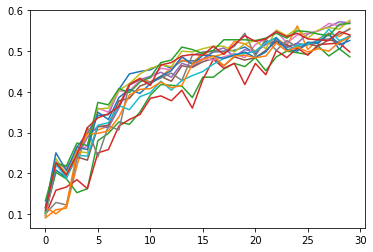

In [642]:
for node in nodelist:
    plt.plot(state_latest[0]['d2d_clus'][node])

In [667]:
result_files[0]

'resultsmnist_niid1_n20_c3_e3_20210818-2144'

In [704]:
# metrics = ['test_acc', 'trg_loss']
metrics = ['cluster_avgacc']
for file in result_files:
    for metric in metrics:
        avgs = plot_avg_sdev(metric, 'resultscifar_niid_n20_c3_e2_20210818-1420', 'Results', './Results/Set2/', True)
        break

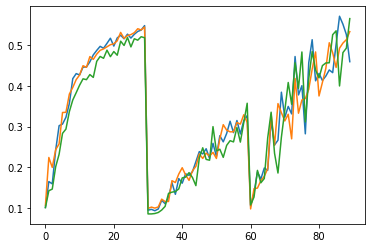

In [705]:
for cluster_id in range(len(avgs['d2d_clus'])):
    plt.plot(avgs['d2d_clus'][cluster_id])

In [708]:
len(avgs['d2d_clus'][0])

90

In [703]:
def plot_avg_sdev(metric, file_name, folder, dest_path, active_ref = False):
    file = os.path.join('.', folder, file_name)
    with open(file, 'rb') as f:
        state =  pickle.load(f)
    if len(state) < 6:
        return
    labels = ['mnist', 'cifar']    
    cats = file_name.split('_')
    for dataset in labels:
        if dataset in cats[0]:
            label = dataset
            break

    dists = ['niid2', 'niid1', 'niid']
    for label_dist in dists:
        if label_dist in cats[1]:
            dist = label_dist
            break
        else:
            dist = 'iid'

    modes = ['d2d_clus', 'd2d', 'centr_fed']
    ref_mode = 'sgd'
    metrics = ['test_acc', 'trg_loss', 'avg_loss', 'divergence', 'avg_acc', 'cluster_set', 'cluster_avgacc']
    
    metric_order = {metric:order for order, metric in enumerate(metrics)}
   
    title_div = metric.upper() + ' ' +  label.upper() + ' : ' + dist.upper() +'-' + cats[2].upper() +'_' + cats[3] + '_' + cats[4]
    if metric == 'test_acc' or metric == 'trg_loss':
        mode_roundstat = {mode:[] for mode in modes}
        mode_roundupper = {mode:[] for mode in modes}
        mode_roundlower = {mode:[] for mode in modes}
        mode_round_avgstat = {mode:[] for mode in modes}
        
        figure = plt.figure(figsize = (15, 10))
        for mode in modes:
            # List of nodes part of clusters
            nodes_list = final_list(state[5], len(state[metric_order[metric]][mode]))

            for rnd in range(len(state[metric_order[metric]][mode][0])):
                round_stat = []
                round_mean = 0
                round_sdev = 0

                for node in nodes_list:
                    round_stat.append(state[metric_order[metric]][mode][node][rnd])

                mode_roundstat[mode].append(round_stat)
                round_mean = statistics.mean(round_stat)
                round_sdev = statistics.stdev(round_stat)

                mode_round_avgstat[mode].append(round_mean)
                mode_roundupper[mode].append(round_mean + round_sdev)
                mode_roundlower[mode].append(round_mean - round_sdev)

            plt.grid()
            plt.plot(mode_round_avgstat[mode])
            plt.fill_between(list(range(len(mode_roundupper[mode]))), mode_roundupper[mode], mode_roundlower[mode], alpha = 0.3)

        if active_ref:
            plt.plot(state[metric_order[metric]][ref_mode])
            modes.append(ref_mode)
            plt.legend(modes)
            modes.remove(ref_mode)
        else:
            plt.legend(modes)
        plt.xlabel('Rounds', size = 10)
        plt.ylabel(metric.upper(), size = 10)
        plt.title(title_div, size = 20)
        filename = title_div + '_' + cats[5]
        save_path = os.path.join(dest_path, filename)
        plt.savefig(save_path)
        plt.close(figure)
            
    elif metric == 'avg_loss' or metric == 'avg_acc':
        "Plotting node averages"
        figure = plt.figure(figsize = (15,10))
        plt.grid()
        for mode in modes:
            plt.plot(state[metric_order[metric]][mode])
            plt.xlabel('Rounds')
            plt.ylabel(metric.upper())
            plt.title(title_div, size = 20)
        if active_ref:
            plt.plot(state[metric_order[metric]][ref_mode])
            modes.append(ref_mode)
            plt.legend(modes)
            modes.remove(ref_mode)
        else:
            plt.legend(modes)

        filename = title_div + '_' + cats[5]
        save_path = os.path.join(dest_path, filename)
        plt.savefig(save_path)        
        plt.close(figure)
        
    elif 'divergence' in metric:
        num_rounds = len(state[metric_order[metric]])
        modes = list(state[metric_order[metric]][0].keys())
        divergence = {mode:None for mode in modes}
        figure = plt.figure(figsize = (15,10))

        for mode in modes:
            nn_divergence = {key:[] for key in state[metric_order[metric]][0][mode].keys()}
            for nn_key in state[metric_order[metric]][0][mode].keys():
                if 'weight' in nn_key:
                    for rnd in range(num_rounds):
                        round_divergence = 0
                        for i in range(len(state[metric_order[metric]][0][mode][nn_key])):
                            round_divergence += state[metric_order[metric]][rnd][mode][nn_key][i].item()
                        round_divergence = round_divergence / i
                        nn_divergence[nn_key].append(round_divergence)
            divergence[mode] = nn_divergence
            legends = []
            for keys in nn_divergence.keys():
                if 'weight' in keys:
                    plt.plot(divergence[mode][keys])
                    legends.append(keys)
            plt.legend(legends)
            plt.title(title_div, size = 20)
        filename = title_div + '_' + cats[5]
        save_path = os.path.join(dest_path, filename)
        plt.savefig(save_path)        
        plt.close(figure)
        
    elif 'cluster_avgacc' in metric:
        
        cluster_set = state[5]
        cluster_avgacc = {mode:None for mode in modes}
        cluster_avgstat = {cluster_id:[] for cluster_id in range(len(cluster_set))}
        
        for mode in modes:
            for cluster_id in range(len(cluster_set)):
                for rnd in range(len(state[0][mode][0])):
                    acc = 0
                    for node in cluster_set[cluster_id]:
                        acc += state[0][mode][node][rnd]
                    acc = acc / len(cluster_set[cluster_id])
                    cluster_avgstat[cluster_id].append(acc)
            cluster_avgacc[mode] = cluster_avgstat
        
        return cluster_avgacc
                
        
        
    

In [237]:
import matplotlib.pyplot as plt
import pickle

def plot_bar(file_name):
    file = './Results/Results-2/' + file_name
    with open(file, 'rb') as f:
        state =  pickle.load(f)
    num_nodes = len(state[0]['d2d_clus'])
    labels = ['mnist', 'cifar']
    
    cats = file_name.split('_')
        
    for dataset in labels:
        if dataset in cats[0]:
            label = dataset
            break
            
    dists = ['niid2', 'niid1', 'niid']
    for label_dist in dists:
        if label_dist in cats[1]:
            dist = label_dist
            break
        else:
            dist = 'iid'
            
    gap = 0.35
    keys = np.array(list(range(num_nodes)))
    fig1 = plt.figure(figsize = (20, 10))
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.grid()
    plt.bar(keys-gap/2, state[0]['d2d_clus'].values(), gap-0.2, label = 'd2d_clus')
    plt.bar(keys, state[0]['d2d'].values(), gap-0.2)
    plt.bar(keys+gap/2, state[0]['centr_fed'].values(), gap-0.2)
    plt.legend(['Clustered D2D', 'D2D', 'Centr FL'])
    title_acc = 'Accuracy Comparison for ' + label.upper() + ' : ' + dist.upper()
    plt.title(title_acc, size = 30)
    plt.xlabel('Nodes', size = 20)
    plt.ylabel('Accuracies', size = 20)
    plt.savefig('./Fig_results/' + title_acc + cats[2])
    
    for mode in state[0].keys():
        if mode != 'sgd':
            fig = plt.figure(figsize = (15,10))
            plt.grid()
            title_loss = 'Loss Comparison for ' + mode.upper() + ' ' + label.upper() + ' : ' + dist.upper()
            for node in state[1][mode].keys():
                plt.plot(state[1][mode][node])
                plt.xlabel('Aggregation Rounds', size = 20)
                plt.ylabel('Training Loss', size = 20)
                plt.title(title_loss, size = 30)
            plt.savefig('./Fig_results/' + title_loss + cats[2])
    
    fig = plt.figure(figsize  = (15, 10))
    plt.grid()
    
    for mode in state[0].keys():
        title_avgloss = 'Average Loss Comparison for ' + label.upper() + ' : ' + dist.upper()
        if mode != 'sgd':
            plt.plot(state[2][mode])
        plt.legend([mode for mode in state[0].keys() if mode != 'sgd'])
        plt.title(title_avgloss, size = 25)
        plt.xlabel('Aggregation Rounds', size = 20)
        plt.ylabel('Average Training Loss for Nodes', size = 20)
        plt.savefig('./Fig_results/' + title_avgloss + cats[2])
        
    nonsgd_modes = ['d2d_clus', 'd2d', 'centr_fed']
    divergence = {mode:[] for mode in nonsgd_modes}
    for mode in nonsgd_modes:
        for i in range(len(state[3][0][mode])):
            divergence[mode].append(state[3][0][mode][i].item())  
    keys = np.array(list(range(len(divergence[mode]))))
    i = -0.3
    plt.figure(figsize = (25, 10))
    plt.bar( keys+i, divergence['d2d_clus'], 0.2)
    plt.bar( keys, divergence['d2d'], 0.2)
    plt.legend(['D2D_Clus', 'D2D'])
    plt.xlabel('Rounds', size = 20)
    title_div = 'Divergence Comparison for ' + label.upper() + ' : ' + dist.upper()
    plt.ylabel(title_div, size =20)
    plt.title(title_div, size =30)
    plt.savefig('./Fig_results/' + title_div + cats[2])